# Train and Optimize

Train a neural network on PANCAN+GTEX gene expression to classify primary site and tumor/normal

Optimize the model using [Hyperband](http://fastml.com/tuning-hyperparams-fast-with-hyperband/) after a subset of genes are identified based on the top Shapely values to determine of the same tumor/normal and disease classification can be achieved.

In [1]:
import sys
import os
import json
import random
import pandas as pd
import numpy as np
import tensorflow as tf

print("GPU Available:", tf.test.is_gpu_available())

# Switch to a scratch data directory so all paths are local
os.makedirs(os.path.expanduser("~/data/pancan-gtex"), exist_ok=True)
os.chdir(os.path.expanduser("~/data/pancan-gtex"))

# Syntatic sugar for debug vs. train parameters
def debug(debug_param, no_debug_param):
    return debug_param if os.environ.get("DEBUG") == "True" else no_debug_param
print(debug("DEBUG: ON", "DEBUG: OFF"))

GPU Available: False
DEBUG: ON


In [43]:
# Setup S3 connection to download and upload data
import boto3

bucket_name = "stuartlab"
session = boto3.session.Session(profile_name=os.getenv("AWS_PROFILE"))
bucket = session.resource("s3", endpoint_url=os.getenv("AWS_S3_ENDPOINT")).Bucket(bucket_name)
print("S3 Profile: {} Endpoint: {} Bucket: {}".format(
    os.getenv("AWS_PROFILE"), os.getenv("AWS_S3_ENDPOINT"), bucket_name))
print("Dataset files checksums and :")
for obj in bucket.objects.filter(Prefix="pancan-gtex"):
    print(obj.last_modified.isoformat(), obj.e_tag[1:-1], obj.key) 

S3 Profile: prp Endpoint: https://s3.nautilus.optiputer.net Bucket: stuartlab
Dataset files checksums and :
2018-11-23T17:26:45.350000+00:00 ef1c9c15b5a1fd836521f0759e57dfa7-120 pancan-gtex
2019-01-18T22:57:17.416000+00:00 db47628dee79f558ad403c0a6cfe163d-2 pancan-gtex/ensemble-to-hugo.tsv
2019-01-18T22:57:13.190000+00:00 2b90ca5a5ea09a6353865afdd76a0ade-64 pancan-gtex/pancan-gtex.h5


## Load and Wrangle Data

In [3]:
if not os.path.exists("pancan-gtex.h5"):
    print("Downloading dataset...")
    bucket.download_file("pancan-gtex/pancan-gtex.h5", "pancan-gtex.h5")
    
print("Loading dataset...")
X = pd.read_hdf("pancan-gtex.h5", "samples")
Y = pd.read_hdf("pancan-gtex.h5", "labels")
print("Loaded {} samples with {} features and {} labels".format(X.shape[0], X.shape[1], Y.shape[1]))

Loading dataset...
Loaded 17277 samples with 7564 features and 40 labels


In [4]:
X.loc["TCGA-ZT-A8OM-01"].sum()

27611.557

In [5]:
# Create a multi-label one-hot for tumor/normal and primary site
from sklearn.preprocessing import LabelEncoder

primary_site_encoder = LabelEncoder()
Y["primary_site_value"] = pd.Series(
    primary_site_encoder.fit_transform(Y["_primary_site"]), index=Y.index, dtype='int32')

tumor_normal_encoder = LabelEncoder()
Y["tumor_normal_value"] = pd.Series(
    tumor_normal_encoder.fit_transform(Y["tumor_normal"]), index=Y.index, dtype='int32')

Y_onehot = np.append(
    Y["tumor_normal_value"].values.reshape(Y.shape[0],-1), 
    tf.keras.utils.to_categorical(Y["primary_site_value"]), axis=1)

In [6]:
# Split into train, validate and test sets strattified on primary site
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)

# Split into train test
for train_index, test_index in split.split(X.values, Y.primary_site_value):
    X_train = X.values[train_index]
    X_test = X.values[test_index]
    Y_train = Y.iloc[train_index]
    Y_test = Y.iloc[test_index]
    Y_onehot_train = Y_onehot[train_index]
    Y_onehot_test = Y_onehot[test_index]

print("Train:", X_train.shape, "Test:", X_test.shape)

# Split test into validate and test
split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_index, test_index in split.split(X_test, Y_test.primary_site_value):
    X_val = X_test[val_index]
    X_test = X_test[test_index]
    Y_val = Y_test.iloc[val_index]
    Y_test = Y_test.iloc[test_index]
    Y_onehot_val = Y_onehot_test[val_index]
    Y_onehot_test = Y_onehot_test[test_index]

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (13821, 7564) Test: (3456, 7564)
Train: (13821, 7564) Val: (1728, 7564) Test: (1728, 7564)


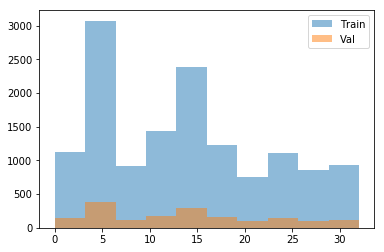

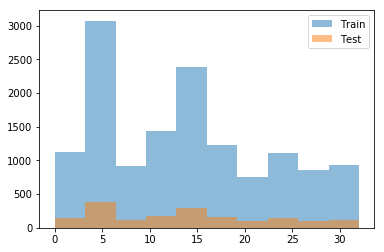

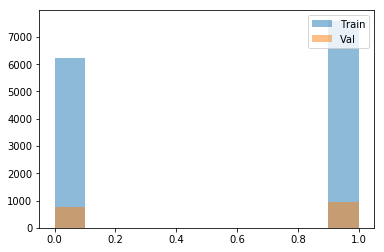

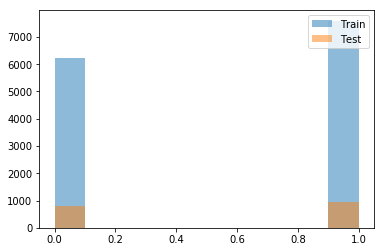

In [14]:
# Plot only in debug as when training we'll be in python on k8s
if os.environ.get("DEBUG") == "True":
    import matplotlib.pyplot as plt

    # Lets see how big each class is based on primary site
    plt.hist(Y_train.primary_site_value.values, alpha=0.5, label='Train')
    plt.hist(Y_val.primary_site_value.values, alpha=0.5, label='Val')
    plt.legend(loc='upper right')
    plt.show()

    plt.hist(Y_train.primary_site_value.values, alpha=0.5, label='Train')
    plt.hist(Y_test.primary_site_value.values, alpha=0.5, label='Test')
    plt.legend(loc='upper right')
    plt.show()

    plt.hist(Y_train.tumor_normal_value.values, alpha=0.5, label='Train')
    plt.hist(Y_val.tumor_normal_value.values, alpha=0.5, label='Val')
    plt.legend(loc='upper right')
    plt.show()


    plt.hist(Y_train.tumor_normal_value.values, alpha=0.5, label='Train')
    plt.hist(Y_test.tumor_normal_value.values, alpha=0.5, label='Test')
    plt.legend(loc='upper right')
    plt.show()

In [10]:
# From https://github.com/PacktPublishing/Deep-Learning-Quick-Reference/blob/master/Chapter06/hyperband.py
import random
from math import log, ceil
from time import time, ctime


class Hyperband:
    def __init__(self, data, get_params_function, try_params_function, max_iter=81, eta=3):
        self.data = data
        self.get_params = get_params_function
        self.try_params = try_params_function

        self.max_iter = debug(2, max_iter)  # maximum iterations per configuration
        self.eta = debug(2, eta)  # defines configuration downsampling rate

        self.logeta = lambda x: log(x) / log(self.eta)
        self.s_max = int(self.logeta(self.max_iter))
        self.B = (self.s_max + 1) * self.max_iter

        self.results = []  # list of dicts
        self.counter = 0
        self.best_loss = np.inf
        self.best_counter = -1

    # can be called multiple times
    def run(self, skip_last=0, dry_run=False):

        for s in list(reversed(range(self.s_max + 1))):

            # initial number of configurations
            n = int(ceil(self.B / self.max_iter / (s + 1) * self.eta ** s))

            # initial number of iterations per config
            r = self.max_iter * self.eta ** (-s)

            # n random configurations
            T = [self.get_params() for i in range(n)]

            for i in list(range((s + 1) - int(skip_last))):  # changed from s + 1

                # Run each of the n configs for <iterations>
                # and keep best (n_configs / eta) configurations

                n_configs = n * self.eta ** (-i)
                n_iterations = r * self.eta ** (i)

                print("\n*** {} configurations x {:.1f} iterations each".format(
                    n_configs, n_iterations))

                val_losses = []
                early_stops = []

                for t in T:


                    self.counter += 1
                    print("\n{} | {} | lowest loss so far: {:.4f} (run {})\n".format(
                        self.counter, ctime(), self.best_loss, self.best_counter))

                    start_time = time()

                    if dry_run:
                        result = {'loss': random(), 'log_loss': random(), 'auc': random()}
                    else:
                        result = self.try_params(self.data, n_iterations, t)

                    assert (type(result) == dict)
                    assert ('loss' in result)

                    seconds = int(round(time() - start_time))
                    print("\n{} seconds.".format(seconds))

                    loss = result['loss']
                    val_losses.append(loss)

                    early_stop = result.get('early_stop', False)
                    early_stops.append(early_stop)

                    # keeping track of the best result so far (for display only)
                    # could do it be checking results each time, but hey
                    if loss < self.best_loss:
                        self.best_loss = loss
                        self.best_counter = self.counter

                    result['counter'] = self.counter
                    result['seconds'] = seconds
                    result['params'] = t
                    result['iterations'] = n_iterations
                    del result['model']  # So we don't end up with hundreds of models taking memory
                    tf.keras.backend.clear_session()
                    import gc
                    gc.collect()

                    self.results.append(result)

                # select a number of best configurations for the next loop
                # filter out early stops, if any
                indices = np.argsort(val_losses)
                T = [T[i] for i in indices if not early_stops[i]]
                T = T[0:int(n_configs / self.eta)]

        return self.results

## Build and Train Model

In [11]:
def load_data():
    return {
        "train_X": X_train, "train_y": Y_onehot_train,
        "val_X": X_val, "val_y": Y_onehot_val, 
        "test_X": X_test, "test_y": Y_onehot_test}

def create_model(input_shape, output_shape, params={"depth": 2, "width": 64, "penalty": 0.05}):
    inputs = tf.keras.layers.Input(shape=(input_shape,))

    x = tf.keras.layers.BatchNormalization()(inputs)
        
    for i in range(params["depth"]):
        x = tf.keras.layers.Dense(params["width"], activation="relu",
                           activity_regularizer=tf.keras.regularizers.l1(params["penalty"]))(x)
        x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(output_shape, activation="sigmoid")(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

    return model

def get_params():
    return {
        "batchsize": random.choice([64, 128, 256]),
        "depth": random.choice([2, 3, 4, 5]),
        "width": random.choice([32, 64, 128]),
        "penalty": random.choice([1e-5, 1e-3, 1e-2]),
    }

def try_params(data, num_iters, params):
    model = create_model(X_train.shape[1], Y_onehot_train.shape[1], params)
#     if os.environ.get("DEBUG"):
#         model.summary()
    
    early_stopping_monitor = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=2, verbose=1)
    history = model.fit(x=data["train_X"], y=data["train_y"],
              batch_size=params["batchsize"],
              epochs=int(num_iters),
              callbacks = [early_stopping_monitor])
    loss, acc = model.evaluate(x=data["val_X"], y=data["val_y"], verbose=1)
    return {"loss": loss, "acc": acc, "model": model, "early_stop": early_stopping_monitor.stopped_epoch != 0}


data = load_data()
hyperband = Hyperband(data, get_params, try_params)

results = hyperband.run()

# import cProfile
# cProfile.run("results = hyperband.run()", "stats")

print("Completed training.")

print("Top parameter combinations:")
print(sorted(results, key=lambda r: r["loss"])[0])


*** 2 configurations x 1.0 iterations each

1 | Fri Jan 18 23:36:20 2019 | lowest loss so far: inf (run -1)

Epoch 1/1
1728/1728 [==============================] - 1s 359us/step

17 seconds.

2 | Fri Jan 18 23:36:37 2019 | lowest loss so far: 4.4820 (run 1)

Epoch 1/1
1728/1728 [==============================] - 1s 358us/step

14 seconds.

*** 1.0 configurations x 2.0 iterations each

3 | Fri Jan 18 23:36:52 2019 | lowest loss so far: 2.7751 (run 2)

Epoch 1/2
13821/13821 [==============================] - 7s 528us/step - loss: 169.9936 - acc: 0.7836
Epoch 2/2
1728/1728 [==============================] - 1s 326us/step

17 seconds.

*** 2 configurations x 2.0 iterations each

4 | Fri Jan 18 23:37:09 2019 | lowest loss so far: 1.3127 (run 3)

Epoch 1/2
13821/13821 [==============================] - 7s 538us/step - loss: 11.0133 - acc: 0.89711s - l - ETA: 0s - loss: 11.6704 -
Epoch 2/2
1728/1728 [==============================] - 1s 350us/step

17 seconds.

5 | Fri Jan 18 23:37:26 2019 |

In [12]:
print("Training on best parameters...")

params = sorted(results, key=lambda r: r["loss"])[0]["params"]

print(params)

model = create_model(X_train.shape[1], Y_onehot_train.shape[1], params)
if os.environ.get("DEBUG"):
    model.summary()
model.fit(X_train, Y_onehot_train,
          batch_size=params["batchsize"], epochs=debug(1, 100),
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor="loss", patience=2, verbose=1)])

loss, acc = model.evaluate(X_test, Y_onehot_test, steps=1)
print("Acc: {} Loss: {}".format(acc, loss))

Training on best parameters...
{'batchsize': 64, 'width': 64, 'depth': 5, 'penalty': 0.01}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7564)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7564)              30256     
_________________________________________________________________
dense (Dense)                (None, 64)                484160    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
___________________________________________________

In [47]:
# Save the trained model and parameters to S3 for use in evaluate prefix with debug
# so we don't clobber the fully trained model when modifying this notebook locally
bucket.Object("{}/pancan-gtex/models/params{}.json".format(os.environ["USER"], debug("-debug", ""))).put(
    Body=json.dumps({
        "tumor_normal": tumor_normal_encoder.classes_.tolist(),
        "primary_site": primary_site_encoder.classes_.tolist(),
        "test_ids": list(Y_test.index.values)}), 
    ACL="public-read")

import tempfile
src = "/tmp/{}.h5".format(next(tempfile._get_candidate_names()))
model.save(src)

bucket.Object("{}/pancan-gtex/models/model{}.h5".format(os.environ["USER"], debug("-debug", ""))).upload_file(
    src, ExtraArgs={"ACL":"public-read"})

print("Trained model files and checksums:")
for obj in bucket.objects.filter(Prefix="{}/pancan-gtex/models/".format(os.environ["USER"])):
    print(obj.last_modified.isoformat(), obj.e_tag[1:-1], obj.key)